<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Testing-pipeline" data-toc-modified-id="Testing-pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Testing pipeline</a></span></li><li><span><a href="#Comparison-Sig-Kernel-and-RBF-Kernel" data-toc-modified-id="Comparison-Sig-Kernel-and-RBF-Kernel-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison Sig-Kernel and RBF-Kernel</a></span></li></ul></div>

In [1]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     
PROJ = 'My Drive/Distribution_Regression_Proj'       

drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)
!mkdir "{PROJECT_PATH}"     # in case we haven't created it already   

GIT_PATH = "https://d1f5fb17f9201eeb70248ecea10d65a859c2fffe@github.com/maudl3116/Distribution_Regression_Streams.git"
!mkdir ./temp
!git clone "{GIT_PATH}"
!mv ./temp/* "{PROJECT_PATH}"
!rm -rf ./temp
!rsync -aP --exclude=data/ "{PROJECT_PATH}"/*  ./


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Cloning into 'Distribution_Regression_Streams'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 87 (delta 45), reused 68 (delta 26), pack-reused 0
Unpacking objects: 100% (87/87), done.
mv: cannot stat './temp/*': No such file or directory
sending incremental file list
rsync: link_stat "/content/drive/My Drive/Distribution_Regression_Proj/*" failed: No such fi

In [0]:
#!git clone 'https://d1f5fb17f9201eeb70248ecea10d65a859c2fffe@github.com/maudl3116/Distribution_Regression_Streams.git'

In [2]:
!pip install iisignature

     |████████████████████████████████| 1.3MB 6.8MB/s 
  Created wheel for iisignature: filename=iisignature-0.24-cp36-cp36m-linux_x86_64.whl size=2528025 sha256=c459bd18948c4349bc6238648dcdf1eb766c44ced31d76b29cb005b917eff662
  Stored in directory: /root/.cache/pip/wheels/57/33/98/2b03151aa0378df847a71a66ab6ed8f7594d310e11dcd60ed7
Successfully built iisignature


In [0]:
import sys
sys.path.append("Distribution_Regression_Streams/")
from importlib import reload
import numpy as np
import data_generators.ellipsis
from data_generators import ellipsis
import utils
from utils import *
import GP_models as GP_models
from GP_models import GP_classic as GP_naive
from GP_models import GP_sig_precomputed as GP_sig
import experiments
from experiments import * 
import signature_features
from signature_features import *

# Description



# Testing pipeline

**Generate data**

In [9]:
reload(ellipsis)

N_bags = 200
N_items = 15
tspan = np.linspace(0.0, 2*np.pi, 501)
spec_param = {'a':[1.,3.], 'b':[1.,3.]} #,'stdv_noise':[None]}

example = ellipsis.Ellipsis()
example.generate_data(N_bags=N_bags,N_items=N_items, t_span = tspan,spec_param=spec_param, stdv_pos=0., stdv_noise=0.3)
example.e_ang()


hi


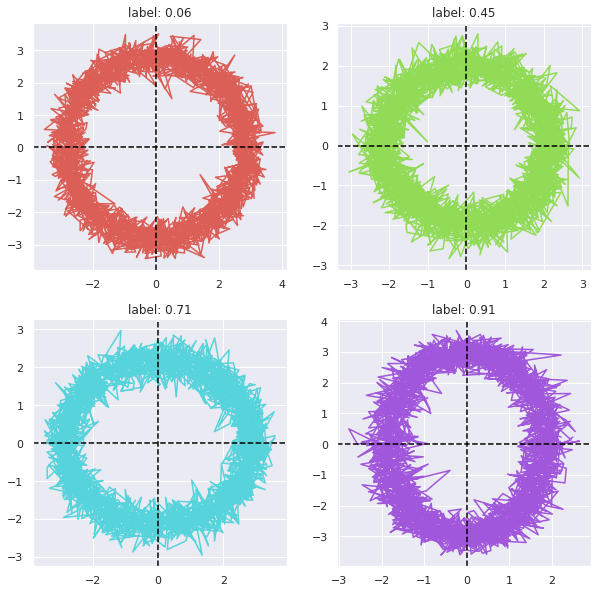

In [5]:
example.plot(N=2)

**Visualize the variability between bags**

We order bags by their labels. We choose N bags amongst all bags, and plot one sample per bag. We also represent a circle which corresponds to $e=0$. We recentre the ellipsis. 

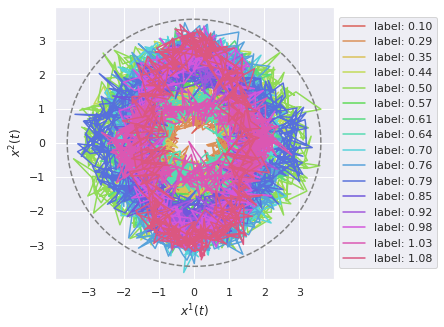

In [7]:
example.one_plot(N=16)

**Linear relationship between vector norm and label?**

We have 2D paths $x_t=(x^1_t,x^2_t)$. Subsampling these paths yields matrices $\mathbf{x}=(\mathbf{x}^1,\mathbf{x}^2)$. To perform distribution regression with an RBF kernel, we stack the two dimensions, yielding $\mathbf{x}_{\mathrm{stack}}=\begin{pmatrix}\mathbf{x}^1\\\mathbf{x}^2\end{pmatrix}$.
We compute the expected value of the squared norms in each back $\mathbb{E}||\mathbf{x}_{\mathrm{stack}}||^2$

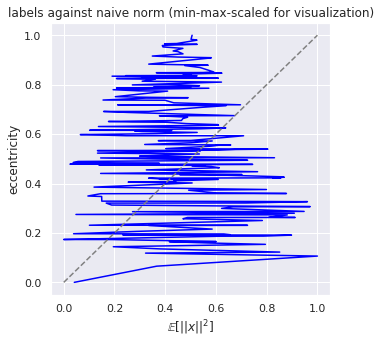

In [8]:
example.compute_plot_naive_norms()

**Subsample the paths**

We can decide to:
- select uniformly, randomly, a set of indices. We choose the same observation grid for each item in a bag. 
- select the first $\ell$ observations


In [0]:
example.subsample_paths(N=100)
#example.plot_subsampled_paths(N=2)

**Test/Train split**

In [0]:
reload(utils)
noisy_labels = example.labels #+0.05*np.random.randn(len(example.labels),1)
data_scaled, y_scaled, train_indices, test_indices = utils.split_standardize(noisy_labels,example.paths_sub,standardized=True,method='stratify')

**Regression GP-RBF**

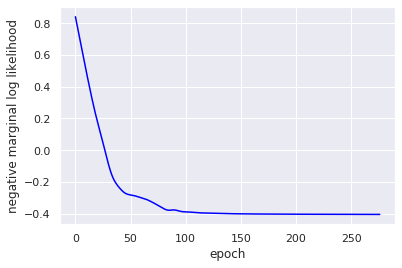

lengtshcale Parameter containing:
tensor([3.1277], device='cuda:0', dtype=torch.float64, requires_grad=True)
noise_obs Parameter containing:
tensor([-6.2241], device='cuda:0', dtype=torch.float64, requires_grad=True)


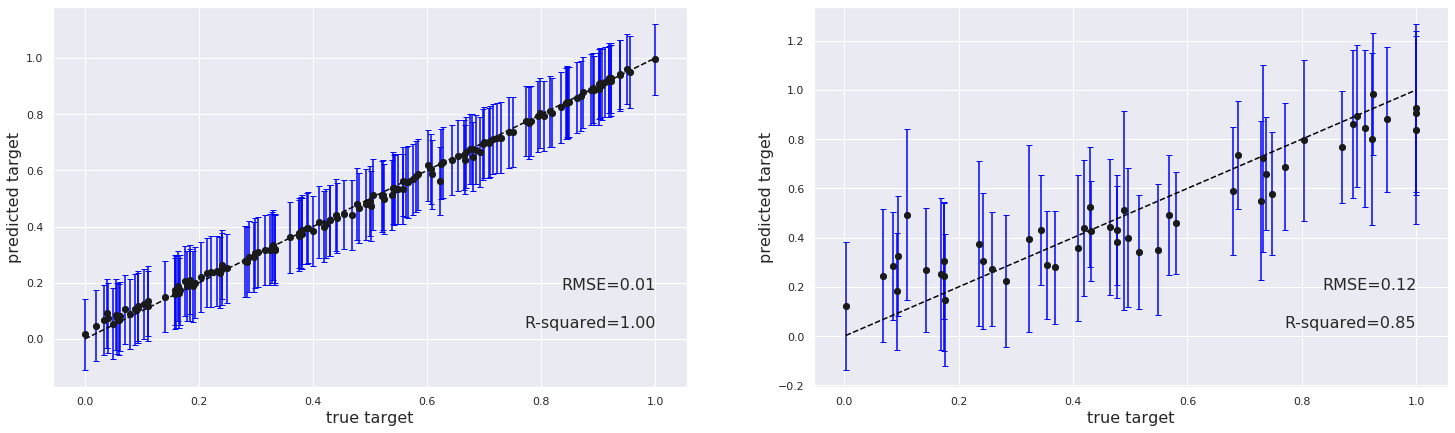

0.8462453080913881


In [8]:
reload(GP_naive)
reload(experiments)
res = []


# stack dimensions
dim_1 = np.array(np.array(data_scaled)[:,:,:,0])
dim_2 = np.array(np.array(data_scaled)[:,:,:,1])
input_ = np.concatenate([dim_1,dim_2],axis=2)


train_naive, test_naive = experiments.naive_experiment(input_, y_scaled ,train_indices,test_indices,param_init=[10,0,0],plot=True,device=torch.device('cuda'))
res.append(test_naive)

print(np.mean(res))

**Regression GP-Sig**

maxi 2000.0


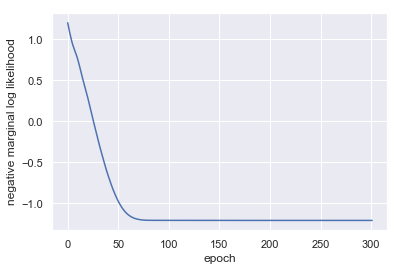

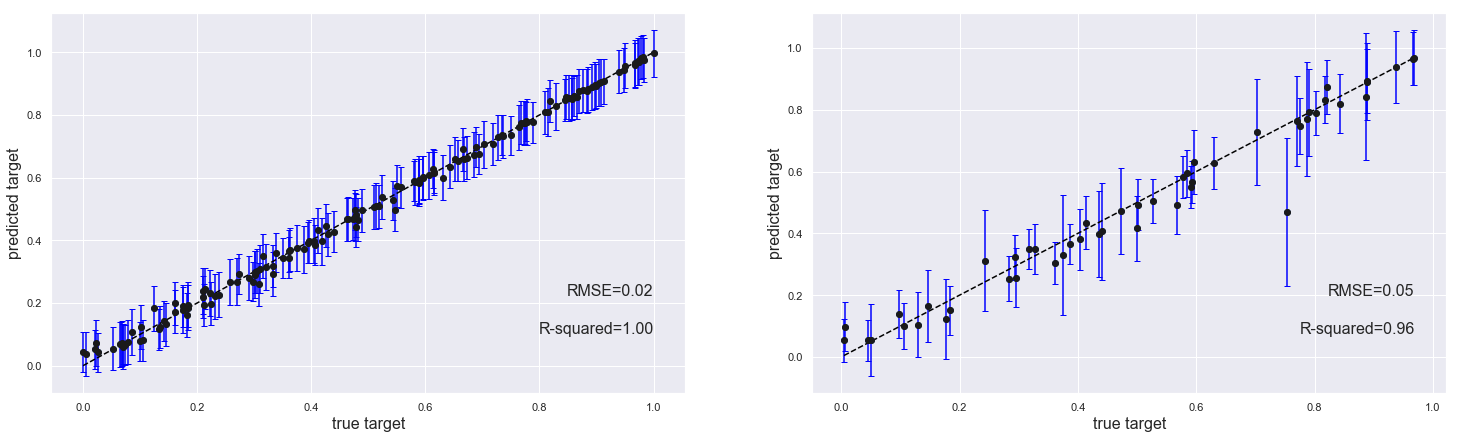

0.9646697168349754


In [0]:
# # specs for expected sig 
reload(signature_features)
reload(experiments)
reload(GP_sig)
sig_level1 = 6
M = 1000

results = []



# pathwise expected sig  
expected_pathwise_sig = signature_features.scaled_expected_sig([e.copy() for e in data_scaled],sig_level1,M=M,a=1,ilya_rescale=True,return_norms=False)
K_precomputed = experiments.precompute_K(expected_pathwise_sig)
train, test = experiments.experiment_precomputed(K_precomputed, y_scaled,train_indices,test_indices, RBF=True,plot=True)
results.append(test)

print(np.mean(results))
      

**Loss landscape**

In [0]:
# reload(GP_naive)
# reload(experiments)
# res = []


# # stack dimensions
# dim_1 = np.array(np.array(data_scaled)[:,:,:,0])
# dim_2 = np.array(np.array(data_scaled)[:,:,:,1])
# input_ = np.concatenate([dim_1,dim_2],axis=2)


# experiments.loss_naive(input_, y_scaled ,train_indices,test_indices)


In [0]:
# reload(signature_features)
# reload(experiments)
# reload(GP_sig)
# sig_level1 = 6
# M = 1000

# results = []



# # pathwise expected sig  
# expected_pathwise_sig = signature_features.scaled_expected_sig([e.copy() for e in data_scaled],sig_level1,M=M,a=1,ilya_rescale=True,return_norms=False)
# K_precomputed = experiments.precompute_K(expected_pathwise_sig)
# experiments.loss_sig(K_precomputed, y_scaled, train_indices,test_indices)


# Comparison Sig-Kernel and RBF-Kernel

- evolution of performances with number of items
- evolution of performances with length time series
- evolution of performances with variance of centre ellipse
- evolution of performances with noise variance

In [6]:
%cd Distribution_Regression_Streams
!git add .
!git commit -m 'test commit colab'
!git config --global user.email "maud.lemercier@spc.ox.ac.uk"
!git config --global user.name "maudl3116"
!git push origin "master"


/content/Distribution_Regression_Streams
[master 48af260] test commit colab
 1 file changed, 1 insertion(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 371 bytes | 371.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/maudl3116/Distribution_Regression_Streams.git
   14d0165..48af260  master -> master
